In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import logging

FORMAT = '%(asctime)s %(message)s'
logging.basicConfig(level='INFO', format=FORMAT, datefmt='%d-%b-%y %H:%M:%S')

sns.set_context("talk")

In [21]:
import pandas as pd


def get_probability_of_state(results, posterior_type='acausal_posterior'):
    fragmented = (results[posterior_type]
                  .sel(state=['Inbound-Fragmented', 'Outbound-Fragmented'])
                  .sum(['state', 'position'])
                  .assign_coords({'state': 'Fragmented'}))
    probability = (results[posterior_type]
                   .sum('position')
                   .drop_sel(state=['Inbound-Fragmented', 'Outbound-Fragmented']))
    return xr.concat((probability, fragmented), dim='state')

def classify_states(probability, probability_threshold=0.8):
    is_classified = (probability > probability_threshold).sum('state').astype(bool)
    max_state = probability.idxmax('state')
    classified_states_by_time = max_state.isel(time=is_classified)

    indexes = np.unique(classified_states_by_time.values, return_index=True)[1]
    classified_states = classified_states_by_time.values[sorted(indexes)]
    is_state = (probability > probability_threshold).sum('time') > 0
    return classified_states_by_time, classified_states, is_state.values


def get_replay_info(data, results):
    classified_states = []
    is_state = []

    for ripple_number in data['ripple_times'].index:
        ripple = data['ripple_times'].loc[ripple_number]

        start_time = ripple.start_time
        end_time = ripple.end_time

        probability = get_probability_of_state(
                        results.sel(time=slice(start_time / np.timedelta64(1, 's'),
                                               end_time / np.timedelta64(1, 's'))))
        _, classified_states_temp, is_state_temp = classify_states(probability)
        classified_states.append(classified_states_temp)
        is_state.append(is_state_temp)
        
    is_state = pd.DataFrame(np.stack(is_state),
                            columns=probability.state,
                            index=data['ripple_times'].index)

    return is_state, classified_states

In [4]:
from src.parameters import ANIMALS
from loren_frank_data_processing import make_epochs_dataframe


epoch_info = make_epochs_dataframe(ANIMALS)
epoch_info = epoch_info.loc[(epoch_info.type == 'run') &
                            (epoch_info.environment == 'wtrack')]
epoch_info

environment type  exposure
animal day epoch                           
Jaq    3   2          wtrack  run       1.0
           4          wtrack  run       2.0
           6          wtrack  run       3.0
           8          wtrack  run       4.0
           10         wtrack  run       5.0
...                      ...  ...       ...
Roqui  5   6          wtrack  run      25.0
           8          wtrack  run      26.0
       6   2          wtrack  run      27.0
           4          wtrack  run      28.0
           6          wtrack  run      29.0

[89 rows x 3 columns]

In [6]:
import os
from src.load_data import load_data
import xarray as xr
from src.parameters import PROCESSED_DATA_DIR

epoch_key = epoch_info.index[0]

epoch_identifier = f"{epoch_key[0]}_{epoch_key[1]:02d}_{epoch_key[2]:02d}"
results_filename = os.path.join(
    PROCESSED_DATA_DIR,
    f"{epoch_identifier}_clusterless_forward_reverse_results.nc"
)

data = load_data(epoch_key,
                 position_to_linearize=['nose_x', 'nose_y'],
                 max_distance_from_well=30,
                 min_distance_traveled=50,
                 )
results = xr.open_dataset(results_filename)

22-Oct-21 10:28:55 Loading position info...
22-Oct-21 10:29:35 Loading multiunit...
22-Oct-21 10:29:53 Loading spikes...
22-Oct-21 10:30:45 Finding ripple times...


In [22]:
replay_info, classified_states = get_replay_info(data, results)
replay_info

,Inbound-Forward,Inbound-Reverse,Outbound-Forward,Outbound-Reverse,Fragmented
replay_number,,,,,
1,False,False,False,False,False
2,False,False,False,False,False
3,False,False,False,False,False
4,False,False,False,False,False
5,False,False,False,False,False
...,...,...,...,...,...
206,False,True,True,True,False
207,False,False,False,True,True
208,False,True,False,False,False


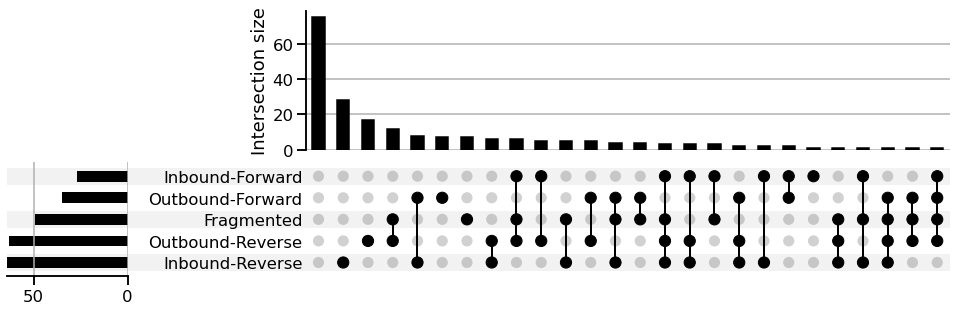

In [16]:
from upsetplot import UpSet

states = ['Inbound-Forward',
          'Inbound-Reverse',
          'Outbound-Forward',
          'Outbound-Reverse',
           'Fragmented']
UpSet(replay_info.reset_index(drop=True).set_index(states),
      sort_by='cardinality',
      show_percentages=False,
      totals_plot_elements=5
     )

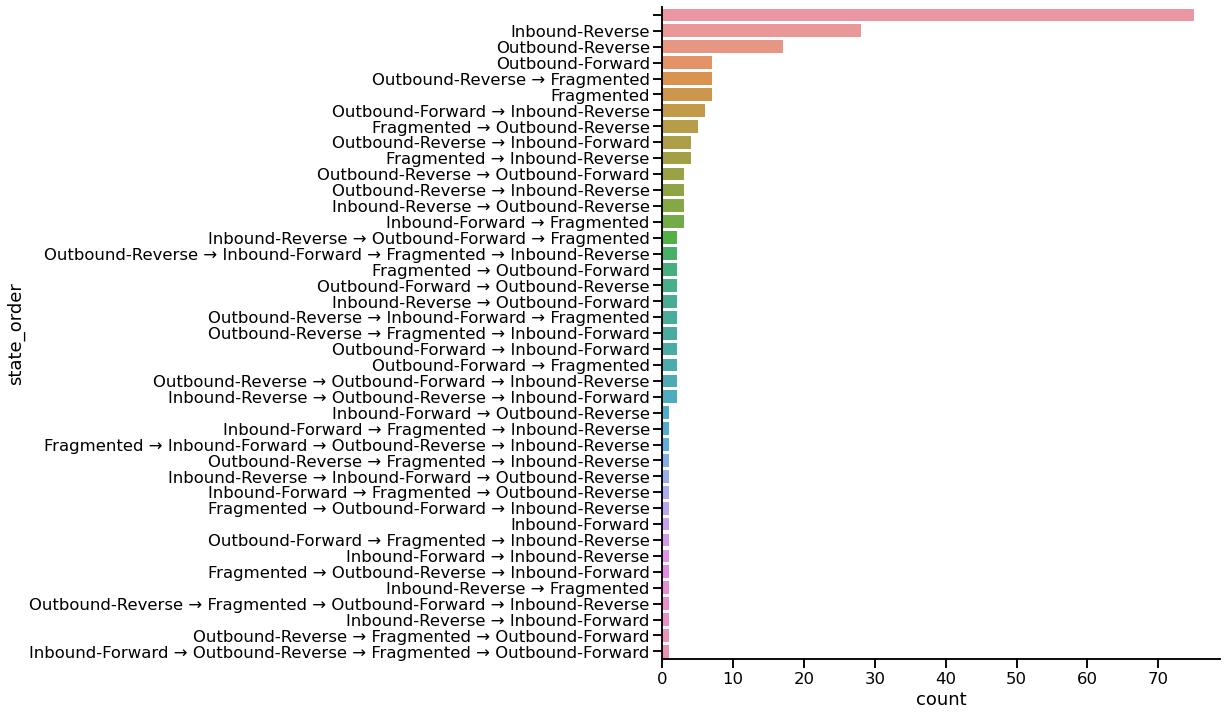

In [23]:
fig, ax = plt.subplots(figsize=(10, 12))
state_order = pd.DataFrame([' → '.join(states) for states in classified_states],
                           columns=['state_order'],
                           index=data['ripple_times'].index)
sns.countplot(y='state_order',
              data=state_order,
              ax=ax,
              order=state_order['state_order'].value_counts().index)
sns.despine()